# TECH CHALLENGE 2 - Prophet


TECH CHALLENGE 2

#Estudando e preparando os dados os Dados


In [1]:
!pip install prophet

  Using cached prophet-1.1.7-py3-none-win_amd64.whl.metadata (3.6 kB)
Using cached prophet-1.1.7-py3-none-win_amd64.whl (13.3 MB)


ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: 'C:\\Users\\T-GAMER\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python311\\site-packages\\prophet\\stan_model\\cmdstan-2.33.1\\stan\\lib\\stan_math\\lib\\tbb_2020.3\\include\\tbb\\internal\\_deprecated_header_message_guard.h'
HINT: This error might have occurred since this system does not have Windows Long Path support enabled. You can find information on how to enable this at https://pip.pypa.io/warnings/enable-long-paths


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: C:\Users\T-GAMER\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [44]:
import pandas as pd

df_ibovespa = pd.read_csv(r"C:\Users\T-GAMER\Documents\Estudos_Matheus_2025\dados_pos\Dados Históricos - Ibovespa (4).csv")

df_ibovespa.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,25.07.2025,133.524,133.820,134.204,133.285,"5,56B","-0,21%"
1,24.07.2025,133.808,135.357,135.363,133.648,"5,98B","-1,15%"
2,23.07.2025,135.368,134.036,135.782,133.676,"6,53B","0,99%"
3,22.07.2025,134.036,134.180,135.300,133.986,"7,05B","-0,10%"
4,21.07.2025,134.167,133.382,134.865,133.367,"6,73B","0,59%"


In [45]:
df_ibovespa['Data'] = pd.to_datetime(
    df_ibovespa['Data'],
    format='%d.%m.%Y',
    errors='raise'
)

df_ibovespa["Vol."] = df_ibovespa["Vol."].str.replace("M", "e6").str.replace("B", "e9").str.replace("K", "e3").str.replace(",", ".").astype(float)

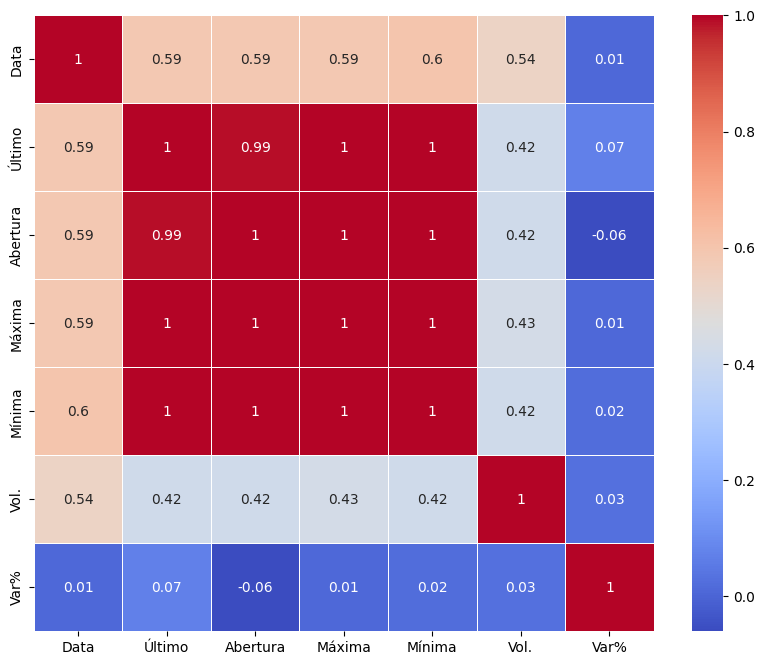

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

df_ibovespa['Var%'] = df_ibovespa['Var%'].astype(str).str.replace('%', '').str.replace(',', '.').astype(float) / 100

correlation_metrics = df_ibovespa.corr().round(2)

fig, ax = plt.subplots(figsize=(10,8))

sns.heatmap(correlation_metrics, annot=True,linewidths= .5, ax=ax, cmap="coolwarm")

plt.show()

In [47]:
df_ibovespa.isnull().sum()

Data        0
Último      0
Abertura    0
Máxima      0
Mínima      0
Vol.        0
Var%        0
dtype: int64

#Iniciando o modelo

In [48]:
from sklearn import metrics
from prophet.plot import add_changepoints_to_plot
from prophet.plot import plot_cross_validation_metric
from prophet import Prophet
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation

In [49]:
df_ibovespa.rename(columns={'Data': 'ds', 'Último': 'y'}, inplace=True)
df_ibovespa.head()

,ds,y,Abertura,Máxima,Mínima,Vol.,Var%
0,2025-07-25,133.524,133.820,134.204,133.285,5.560000e+09,-0.0021
1,2025-07-24,133.808,135.357,135.363,133.648,5.980000e+09,-0.0115
2,2025-07-23,135.368,134.036,135.782,133.676,6.530000e+09,0.0099
3,2025-07-22,134.036,134.180,135.300,133.986,7.050000e+09,-0.0010
4,2025-07-21,134.167,133.382,134.865,133.367,6.730000e+09,0.0059


In [50]:
df_ibovespa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1137 entries, 0 to 1136
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   ds        1137 non-null   datetime64[ns]
 1   y         1137 non-null   float64       
 2   Abertura  1137 non-null   float64       
 3   Máxima    1137 non-null   float64       
 4   Mínima    1137 non-null   float64       
 5   Vol.      1137 non-null   float64       
 6   Var%      1137 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 62.3 KB


In [51]:
df_ibovespa.set_index('ds', inplace=True)

df_ibovespa.reset_index(inplace=True)

train_set = df_ibovespa.iloc[:-30]

test_set = df_ibovespa.iloc[-30:]

m = Prophet()

m.fit(df_ibovespa)

21:56:02 - cmdstanpy - INFO - Chain [1] start processing
21:56:02 - cmdstanpy - INFO - Chain [1] done processing


In [52]:
future = m.make_future_dataframe(periods=60, freq='B')

forecast = m.predict(future)

#Apresentando os resultados

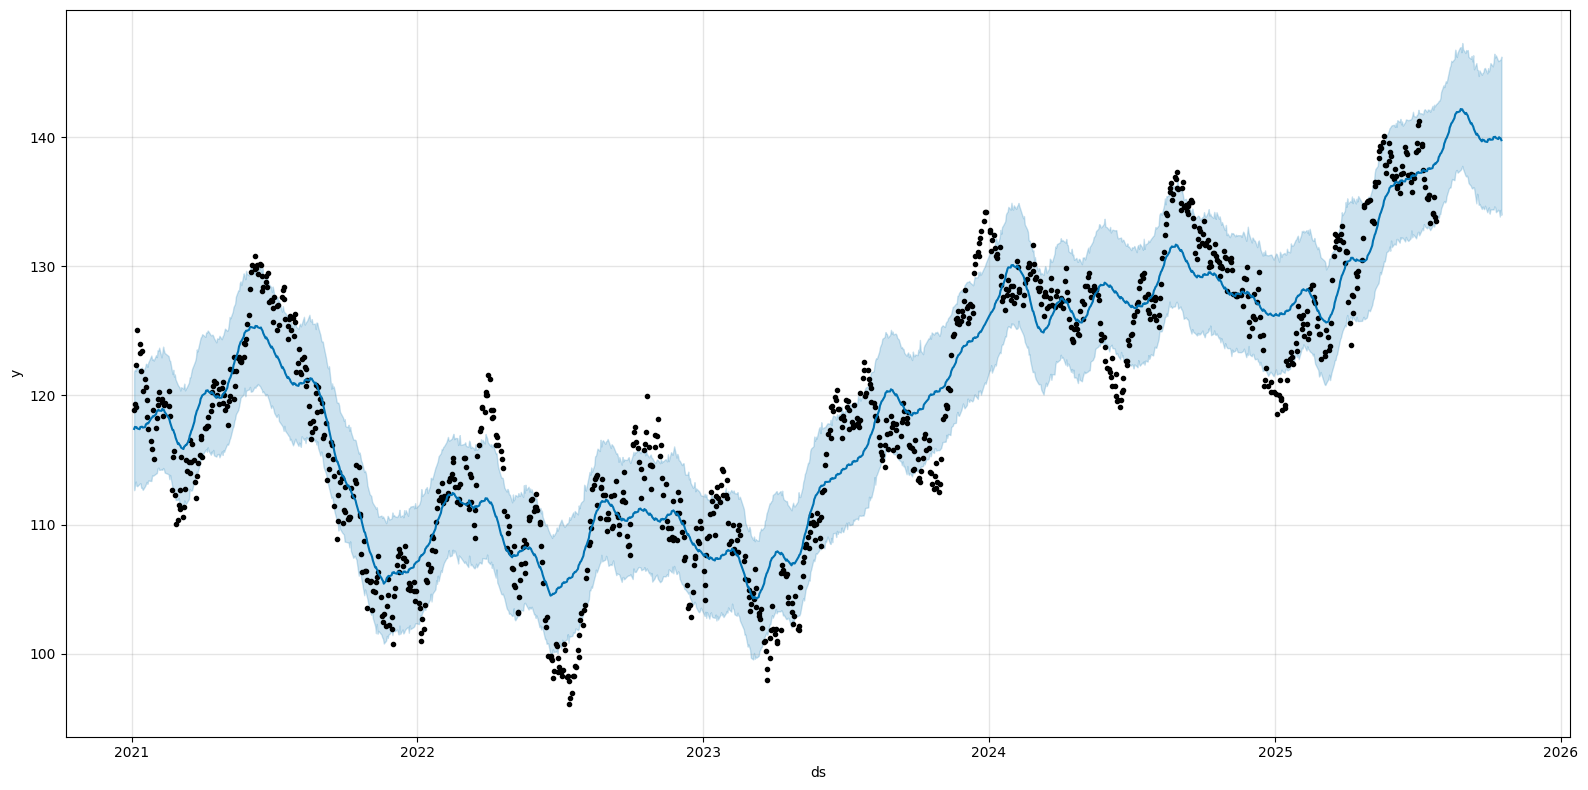

In [53]:
fig = m.plot(forecast, figsize=(16, 8))

In [54]:
import pandas as pd
import numpy as np

# Garante que as datas estão como datetime
df_ibovespa['ds'] = pd.to_datetime(df_ibovespa['ds'])
forecast['ds']    = pd.to_datetime(forecast['ds'])

# Data de corte (último ponto real)
data_corte = df_ibovespa['ds'].max()

# Próximos 30 dias previstos
forecast_future_30 = (
    forecast[
        (forecast['ds'] > data_corte) &
        (forecast['ds'] <= data_corte + pd.Timedelta(days=30))
    ]
    .copy()
    .reset_index(drop=True)
)

# 1) Pega o último valor real do IBOVESPA
last_real = df_ibovespa.loc[df_ibovespa['ds'] == data_corte, 'y'].values[0]

# 2) Cria coluna com o “valor do dia anterior” para comparar
forecast_future_30['prev'] = forecast_future_30['yhat'].shift(1)
forecast_future_30.loc[0, 'prev'] = last_real

# 3) Define Tendência: Subir se yhat > prev, senão Descer
forecast_future_30['Tendência'] = np.where(
    forecast_future_30['yhat'] > forecast_future_30['prev'],
    'Subir',
    'Descer'
)

# 4) Monta a tabela final
tabela = forecast_future_30[['ds', 'yhat', 'Tendência']]
tabela.columns = ['Data', 'Previsão_IBOVESPA', 'Tendência_Próximo_Dia']

# 5) Exibe
print(tabela.to_string(index=False))


      Data  Previsão_IBOVESPA Tendência_Próximo_Dia
2025-07-28         138.182759                 Subir
2025-07-29         138.472927                 Subir
2025-07-30         138.569756                 Subir
2025-07-31         138.724399                 Subir
2025-08-01         138.771110                 Subir
2025-08-04         139.173982                 Subir
2025-08-05         139.516297                 Subir
2025-08-06         139.660700                 Subir
2025-08-07         139.857540                 Subir
2025-08-08         139.940315                 Subir
2025-08-11         140.407947                 Subir
2025-08-12         140.755546                 Subir
2025-08-13         140.896395                 Subir
2025-08-14         141.080582                 Subir
2025-08-15         141.141451                 Subir
2025-08-18         141.488039                 Subir
2025-08-19         141.777490                 Subir
2025-08-20         141.851898                 Subir
2025-08-21  

#Testando modelo #


In [55]:
m = Prophet()
m.fit(train_set)

21:56:15 - cmdstanpy - INFO - Chain [1] start processing
21:56:16 - cmdstanpy - INFO - Chain [1] done processing


In [56]:
future_test = test_set[['ds']]  # só as datas
forecast_test = m.predict(future_test)


In [57]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Valores reais
y_true = test_set['y'].values

# Previsões do modelo
y_pred = forecast_test['yhat'].values

# Métricas
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)

# Print the metrics
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")

MAE: 8.169788317309248
MSE: 72.06863070895946
RMSE: 8.48932451429202


In [58]:
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print(f"MAPE: {mape:.2f}%")

MAPE: 6.80%


21:56:35 - cmdstanpy - INFO - Chain [1] start processing



📈 Previsões dos próximos 30 dias:

      Data  Previsão_IBOVESPA Tendência_Próximo_Dia  Variação_%
2025-07-28             138.18                 Subir        3.49
2025-07-29             138.47                 Subir        0.21
2025-07-30             138.57                 Subir        0.07
2025-07-31             138.72                 Subir        0.11
2025-08-01             138.77                 Subir        0.03
2025-08-04             139.17                 Subir        0.29
2025-08-05             139.52                 Subir        0.25
2025-08-06             139.66                 Subir        0.10
2025-08-07             139.86                 Subir        0.14
2025-08-08             139.94                 Subir        0.06
2025-08-11             140.41                 Subir        0.33
2025-08-12             140.76                 Subir        0.25
2025-08-13             140.90                 Subir        0.10
2025-08-14             141.08                 Subir        0.13
2025

21:56:35 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\T-GAMER\AppData\Local\Temp\ipykernel_5684\975834232.py:117: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\T-GAMER\AppData\Local\Temp\ipykernel_5684\975834232.py:117: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\T-GAMER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\T-GAMER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


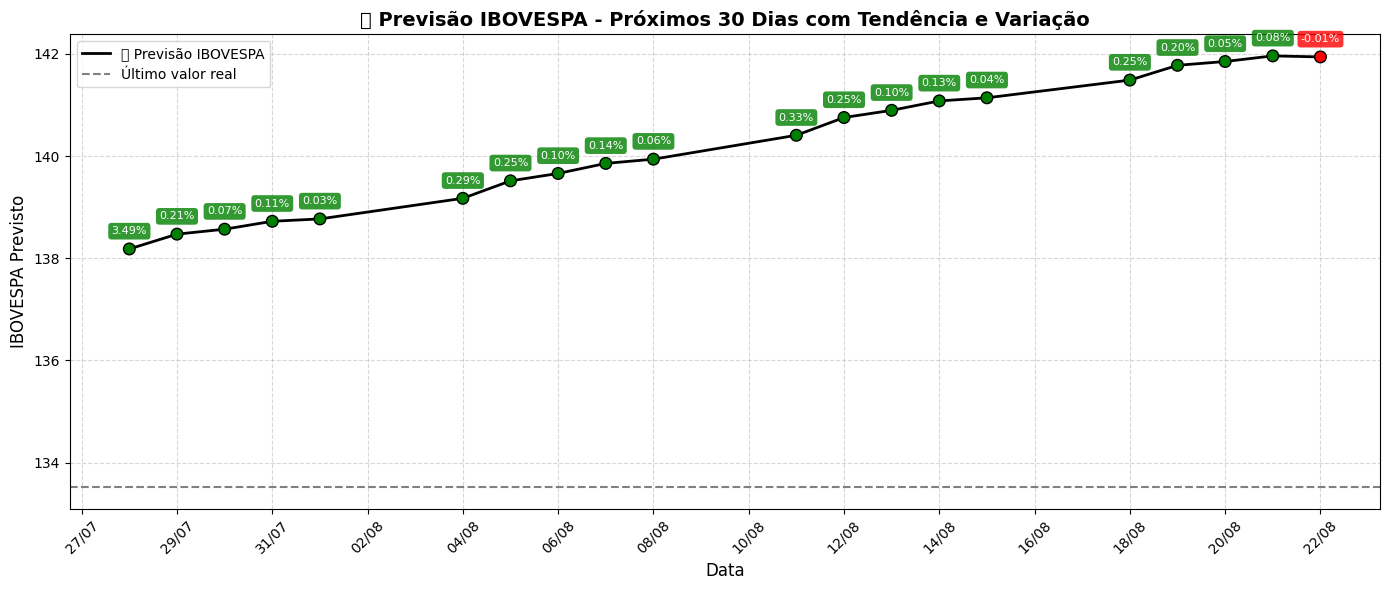

In [59]:
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error

# --- Tratamento de datas ---
df_ibovespa['ds'] = pd.to_datetime(df_ibovespa['ds'])
forecast['ds'] = pd.to_datetime(forecast['ds'])

# Último valor real do IBOVESPA
last_real = df_ibovespa.loc[df_ibovespa['ds'] == df_ibovespa['ds'].max(), 'y'].values[0]

# Previsão dos próximos 30 dias
data_corte = df_ibovespa['ds'].max()
forecast_future_30 = forecast[
    (forecast['ds'] > data_corte) &
    (forecast['ds'] <= data_corte + pd.Timedelta(days=30))
].copy().reset_index(drop=True)

# Valor do dia anterior (shift) e variação
forecast_future_30['prev'] = forecast_future_30['yhat'].shift(1)
forecast_future_30.loc[0, 'prev'] = last_real

forecast_future_30['Tendência'] = np.where(
    forecast_future_30['yhat'] > forecast_future_30['prev'],
    'Subir',
    'Descer'
)

forecast_future_30['Variação_%'] = ((forecast_future_30['yhat'] - forecast_future_30['prev']) / forecast_future_30['prev']) * 100

tabela = forecast_future_30[['ds', 'yhat', 'Tendência', 'Variação_%']].copy()
tabela.columns = ['Data', 'Previsão_IBOVESPA', 'Tendência_Próximo_Dia', 'Variação_%']
tabela['Previsão_IBOVESPA'] = tabela['Previsão_IBOVESPA'].round(2)
tabela['Variação_%'] = tabela['Variação_%'].round(2)

print("\n📈 Previsões dos próximos 30 dias:\n")
print(tabela.to_string(index=False))


# --- Avaliação do modelo ---
y_true = test_set['y'].values
y_pred = forecast_test['yhat'].values

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print("\n🔍 Métricas de desempenho do modelo:")
print(f"MAE:  {mae:.2f}")
print(f"MSE:  {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

m = Prophet(
    daily_seasonality=False,
    weekly_seasonality=True,
    yearly_seasonality=True,
)
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)  # opcional
m.fit(train_set)

import matplotlib.pyplot as plt

data_limite = df_ibovespa['ds'].max() - pd.Timedelta(days=30)

df_real_3m = df_ibovespa[df_ibovespa['ds'] >= data_limite]
forecast_3m = forecast[forecast['ds'] >= data_limite]

# --- Gráfico da Previsão Futura (Próximos 30 dias) ---
# plt.figure(figsize=(12, 6))
# plt.plot(forecast_future_30['ds'], forecast_future_30['yhat'], label='Previsão - Próximos 30 dias', color='blue', marker='o')
# plt.title('📆 Previsão dos Próximos 30 Dias - IBOVESPA')
# plt.xlabel('Data')
# plt.ylabel('Previsão do IBOVESPA')
# plt.grid(True)
# plt.legend()
# plt.axhline(y=last_real, color='gray', linestyle='--', label='Último valor real')
# plt.tight_layout()
# plt.xticks(rotation=45)
# plt.show()
# Mapa de cores baseado na tendência
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Gráfico
fig, ax = plt.subplots(figsize=(14, 6))

# Linha principal
ax.plot(forecast_future_30['ds'], forecast_future_30['yhat'], color='black', linewidth=2, label='📈 Previsão IBOVESPA')

# Pontos coloridos por tendência
cores = forecast_future_30['Tendência'].map({'Subir': 'green', 'Descer': 'red'})
ax.scatter(forecast_future_30['ds'], forecast_future_30['yhat'], color=cores, s=70, edgecolor='black', zorder=5)

# Último valor real
ax.axhline(y=last_real, color='gray', linestyle='--', linewidth=1.5, label='Último valor real')

# Rótulos de variação com caixinha
for i, row in forecast_future_30.iterrows():
    ax.text(row['ds'], row['yhat'] + 0.25, f"{row['Variação_%']:.2f}%",
            ha='center', va='bottom', fontsize=8, color='white',
            bbox=dict(boxstyle='round,pad=0.3', facecolor=cores[i], edgecolor='none', alpha=0.8))

# Formatação de datas
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))

# Títulos e rótulos
plt.title('📊 Previsão IBOVESPA - Próximos 30 Dias com Tendência e Variação', fontsize=14, weight='bold')
plt.xlabel('Data', fontsize=12)
plt.ylabel('IBOVESPA Previsto', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()